# Solving Partial Differential Equations in Julia

## JuliaCon 2018

## Chris Rackauckas

## University of Maryland, Baltimore
## University of California, Irvine

## The goal of this workshop is to show how very disparate parts of the package ecosystem can be joined together to solve PDEs

How are finite elements, multigrid methods, ODE solvers, etc. all the same topic?

Teach a man to fish: we won't be going over pre-built domain specific PDE solvers, instead we will be going over the tools which are used to build PDE solvers. 

#### While the basics of numerically solving PDEs is usually taught in mathematics courses, the way it is described is not suitable for high performance scientific computing. Instead, we will describe the field in a very practical "I want to compute things fast and accurately" style.

## What is a PDE?

A partial differential equation (PDE) is a differential equation which has partial derivatives. Let's unpack that.

A differential equation describes a value (function) by how it changes. `u' = f(u,p,t)` gives you a solution `u(t)` by you inputing / describing its derivative. Scientific equations are encoded in differential equations since experiments uncovers laws about what happens when entities change.

A partial differential equation describes a value by how it changes in multiple directions: how it changes in the `x` vs `y` physical directions, and how it changes in time.

Thus spatial properties, like the heat in a 3D room at a given time, `u(x,y,z,t)` are described by physical equations which are PDEs. Values like how a drug is distributed throughout the liver, or how stress propogates through an airplane hull, are examples of phonomena described by PDEs.

You are interested in PDEs.

## Part 1: Representations of PDEs as other mathematical problems

This will either be an overview where I will reframe the most common method of solution, or your first walkthrough of a PDE solver!

## The best way to solve a PDE is...

## By converting it into another problem!

Generally, PDEs are converted into:

- Linear systems: `Ax = b` find `x`.
- Nonlinear systems: `G(x) = 0` find `x`.
- ODEs: `u' = f(u,p,t)`, find `u`.

There are others:

- SDEs: `du = f(u,p,t)dt + g(u,p,t)dW`, find `mean(u)`.

... Yes experts, there are more but we will stick to the usual stuff.

## Learning by example: the Poisson Equation

Let's introduce some shorthand: $u_x = \frac{\partial u}{\partial x}$. The Poisson Equation is the PDE:

$$ \Delta u(x) = b(x) $$

for $ x \in [0,1]$. In one dimension: 

$$u_{xx} = b$$

$b(x)$ is some known constant function (known as "the data"). Given the data (the second derivative), find $u$.

### How do we solve this PDE?

## First Choice: Computational Representation of a Function

First we have to choose how to computationally represent our continuous function $u(x)$ by finitely many numbers. Let's start with the most basic way (and we'll revisit the others later!). Let $\Delta x$ be some constant discretization size and let $x_i = i\Delta x$. Then we represent our function $u(x) \approx {u_i} = {u(x_i)}$, i.e. we represent a continuous function by values on a grid (and we can assume some interpolation, like linear interpolation)

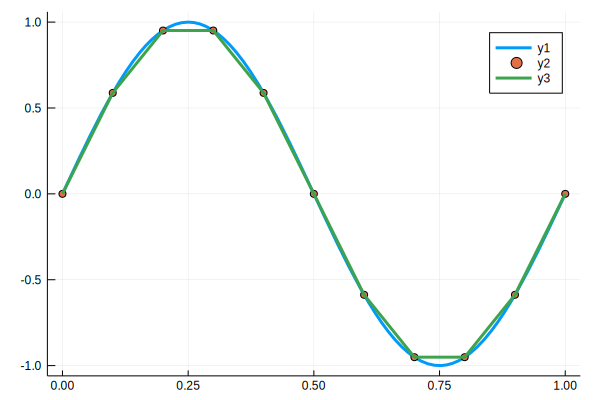

In [13]:
Δx = 0.1
x = 0:Δx:1
u(x) = sin(2π*x)
using Plots
plot(u,0,1,lw=3)
scatter!(x,u.(x))
plot!(x,u.(x),lw=3)

## Second Choice: Discretization of Derivatives

Forward difference: $ u_x \approx \delta^+ u = \frac{u_{i+1} - u_{i}}{\Delta x} $

Backward difference: $ u_x \approx \delta^- u = \frac{u_{i} - u_{i-1}}{\Delta x} $

$$ u_{xx} = \frac{\partial u_x}{\partial x} $$

Central difference for 2nd derivative: $ u_{xx} \approx \delta u_{x} = \frac{\delta^+ u_x - \delta^- u_x}{\Delta x}$

This gives the well-known central difference formula:

$$ u_{xx} \approx \frac{u_{i+1} - 2u_i + u_{i-1}}{\Delta x^2} $$

## Quick Recap

We just made **two choices**:

- Represent our function by an evenly spaced grid of points
- Represent the derivative by the central difference formula

Given these two choices, how can we re-write our PDE?

## The Representation of Our PDE

Remember we want to solve $ \Delta u = b $ on $ x \in [0,1] $

- $u(x)$ is now a vector of points $u_i = u(x_i)$
- $b(x)$ is now a vector of points $b_i = b(x_i)$ 
- The second derivative is now the function $\frac{\partial^2 u}{\partial x}(x_i) = \frac{u_{i+1} - 2u_i + u_{i-1}}{\Delta x^2}$

Thus we have a system of $i$ equations:

$$ \frac{u_{i+1} - 2u_i + u_{i-1}}{\Delta x^2} = b_i $$

## But Wait...

What happens at $i=0$?

$$ \frac{u_1 - 2u_0 + u_{i-1}}{\Delta x^2} = b_0 $$

Translating back to $u_i = u(x_i) = u(i\Delta x)$:

$$ u(\Delta x) - 2u(0) + u(-\Delta x)$$

The last point is out of the domain! In order to solve this problem we have to impose **boundary conditions**. For example, let's add the following condition to our problem: $u(0) = u(1) = 0$. Then the $0$th point is determined: $u_0 = 0$, and the 1st point is:

$$ b_1 = \frac{u_2 - 2u_1 + u_0}{\Delta x^2} = \frac{u_2 - 2u_1}{\Delta x^2} $$

so we can solve it!

## The Linear Representation of Our Derivative

Notice that if $$ U=\left[\begin{array}{c}
u_{1}\\
u_{2}\\
\vdots\\
u_{N-1}\\
u_{N}
\end{array}\right], $$ then

$$ AU=\frac{1}{\Delta x^{2}}\left[\begin{array}{ccccc}
-2 & 1\\
1 & -2 & 1\\
 & \ddots & \ddots & \ddots\\
 &  & 1 & -2 & 1\\
 &  &  & 1 & -2
\end{array}\right]\left[\begin{array}{c}
u_{1}\\
u_{2}\\
\vdots\\
u_{N-1}\\
u_{N}
\end{array}\right]=\frac{1}{\Delta x^{2}}\left[\begin{array}{c}
u_{2}-2u_{1}\\
u_{3}-2u_{2}+u_{1}\\
\vdots\\
u_{N}-2u_{N-1}+u_{N-2}\\
-2u_{N}+u_{N-1}
\end{array}\right]=\left[\begin{array}{c}
b_{1}\\
b_{2}\\
\vdots\\
b_{N-1}\\
b_{N}
\end{array}\right]=B $$

## This is a linear equation!

We know $A$, $B$ is given to us, find $U$.

Let's walk through a concrete version with some Julia code now. Let's solve:

$$ u_{xx} = sin(2\pi x) $$

In [37]:
Δx = 0.1
x = Δx:Δx:1-Δx # Solve only for the interior: the endpoints are known to be zero!
N = length(x)
B = sin.(2π*x)
A = zeros(N,N)
for i in 1:N, j in 1:N
  abs(i-j)<=1 && (A[i,j]+=1)
  i==j && (A[i,j]-=3)
end
A = A/(Δx^2)

9×9 Array{Float64,2}:
 -200.0   100.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0
  100.0  -200.0   100.0     0.0     0.0     0.0     0.0     0.0     0.0
    0.0   100.0  -200.0   100.0     0.0     0.0     0.0     0.0     0.0
    0.0     0.0   100.0  -200.0   100.0     0.0     0.0     0.0     0.0
    0.0     0.0     0.0   100.0  -200.0   100.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0   100.0  -200.0   100.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0   100.0  -200.0   100.0     0.0
    0.0     0.0     0.0     0.0     0.0     0.0   100.0  -200.0   100.0
    0.0     0.0     0.0     0.0     0.0     0.0     0.0   100.0  -200.0

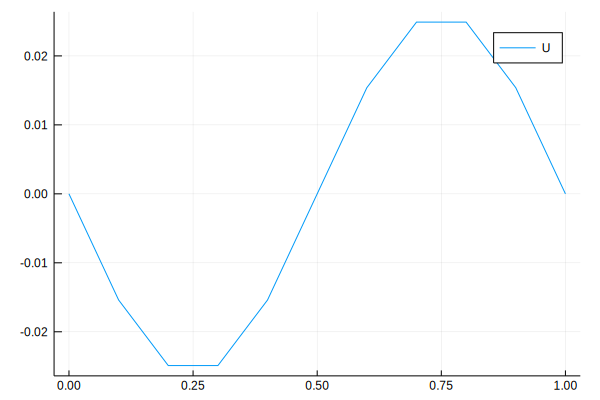

In [42]:
# Now we want to solve AU=B, so we use backslash:
U = A\B
plot([0;x;1],[0;U;0],label="U")

## Did we do that correctly?

This equation is simple enough we can check via the analytical solution. 

$$ u_{xx} = sin(2\pi x) $$

Integrate it twice:

$$ u(x) = -\frac{sin(2\pi x)}{4\pi^2} $$

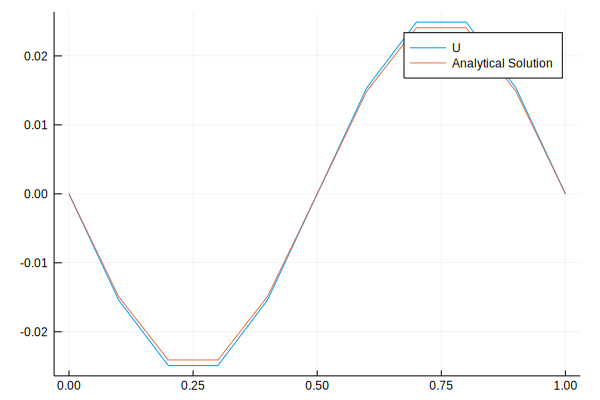

In [43]:
# Now we want to solve AU=B, so we use backslash:
plot([0;x;1],[0;U;0],label="U")
plot!([0;x;1],-sin.(2π*[0;x;1])/4(π^2),label="Analytical Solution")

## Recap

We solved the PDE $$\Delta u = b $$ by transforming our functions into vectors of numbers $U$ and $B$, transforming second derivative into a linear operator (a matrix) $A$, and solving $AU = B$ using backslash.

Does this method generally apply?

Pretty much.

#### Because derivatives are linear, when you discretize a function, the derivative operators become linear operators = matrices

## Semilinear Poisson Equation

$$ \Delta u = f(u) $$

Now the right hand side is dependent on $u$! Let's choose the same discretization and the same representation of the derivatives. Then once again $ \Delta u = AU$ for the same matrix $A$. Now we get the equation:

$$ AU = f(U) $$

Find the vector of $U$ which satisfy this nonlinear system! If we redefine:

$$ G(U) = f(U) - AU $$

then we are looking for the vector $U$ which causes $G(U) = 0$.

#### tl;dr: Semilinear equations convert into nonlinear rootfinding problems

## Semilinear Heat Equation

$$ u_t = u_{xx} + f(u,t) $$

Discretize the function the same way as before. This once again makes $u_{xx} = AU$. Thus letting $U_t$ be the time derivative of each point in the vector, we get:

$$ U_t = AU + f(U,t) $$

but since there's now only one coordinate, let the derivative be by time. Then we can write this as:

$$ U' = AU + f(U,t) $$

This is an ODE!

#### tl;dr: Time-dependent PDEs (can) convert into ODE problems!

## Loose End: Higher Dimensions Do The Same Thing

Now let's look at $$ \Delta u = u_{xx} + u_{yy} = b(x,y) $$ on $x \in [0,1], y \in [0,1]$. 

In this case, you can let $u_{i,j} = u(x_i,y_i)$ where $x_i = i\Delta x$ and $y_i = i\Delta y$. You can list out all of the $u_{i,j}$ into a vector $U$ by lexicographic ordering:

$$ U=\left[\begin{array}{c}
u_{1,1}\\
u_{2,1}\\
\vdots\\
u_{N-1,}\\
u_{N,1}\\
u_{1,2}\\
\vdots\\
u_{N,M}
\end{array}\right] $$

$$ \Delta u = u_{xx} + u_{yy} \approx \frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{\Delta x^2} + \frac{u_{i,j+1} -2 u_{i,j} + u_{i,j-1}}{\Delta y^2} = AU$$

for some A. Now solve $AU=B$

## Part 1 Summary

To solve a PDE, 

- You choose a way to represent functions.
- You choose a way to represent your derivative (and on the function representation, your derivative representation is a matrix!)

Then when you write out your PDE, you get one of the following problems:

- Linear systems: `Ax = b` find `x`.
- Nonlinear systems: `G(x) = 0` find `x`.
- ODEs: `u' = f(u,p,t)`, find `u`.

## Part 2: The Many Ways to Discretize

There are thus 4 types of packages in the PDE solver pipeline:

- Packages with ways to represent functions as vectors of numbers and their derivatives as matrices
- Packages which solve linear systems
- Packages which solve nonlinear rootfinding problems
- Packages which solve ODEs

In this part we will look at the many ways you can discretize a PDE.

## Part 2.1: Packages to Represent Functions and Derivatives

There are four main ways to represet functions and derivatives as vectors:

- Finite difference method (FDM): functions are represented on a grid. Packages: DiffEqOperators.jl (still developing)
- Finite volume method (FVM): functions are represented by a discretization of its integral. Currently no strong generic package support.
- Finite element method (FEM): functions are represented by a local basis. FEniCS.jl, JuliaFEM and JuAFEM.jl
- Spectral methods: functions are represented by a global basis. FFTW.jl and ApproxFun.jl 

## Finite Difference method: DiffEqOperators.jl

DiffEqOperators.jl is part of the JuliaDiffEq ecosystem. It automatically develops lazy operators for finite difference discretizations (functions represented on a grid). For example, to represent $u_{xx}$, we'd do:

In [46]:
using DiffEqOperators
# Second order approximation to the second derivative
order = 2
deriv = 2
Δx = 0.1
N = 9
A = DerivativeOperator{Float64}(order,deriv,Δx,N,:Dirichlet0,:Dirichlet0)

DiffEqOperators.DerivativeOperator{Float64,StaticArrays.SArray{Tuple{3},Float64,1,3},:Dirichlet0,:Dirichlet0}(2, 2, 0.1, 9, 3, [1.0, -2.0, 1.0], (3, 3), (4, 4), Base.RefValue{Array{Array{Float64,1},1}}(Array{Float64,1}[]), Base.RefValue{Array{Array{Float64,1},1}}(Array{Float64,1}[]), Base.RefValue{Tuple{Tuple{Float64,Float64,Any},Tuple{Float64,Float64,Any}}}(((1.0, 0.0, 0.0), (1.0, 0.0, 0.0))), Base.RefValue{Int64}(0))

This `A` is lazy: it acts `A*u` like it was a matrix but without ever building the matrix by overloading `*` and directly computing the coefficients. This makes it efficient, using $\mathcal{O}(1)$ memory while not having the overhead of sparse matrices!

This package also makes it easy to generate the matrices without much work. For example, let's get a 2nd order discretization of $u_{xxxx}$:

In [49]:
full(DerivativeOperator{Float64}(4,2,Δx,N,:Dirichlet0,:Dirichlet0))

9×9 Array{Float64,2}:
  60000.0  -40000.0   10000.0       0.0  …       0.0       0.0       0.0
 -40000.0   60000.0  -40000.0   10000.0          0.0       0.0       0.0
  10000.0  -40000.0   60000.0  -40000.0          0.0       0.0       0.0
      0.0   10000.0  -40000.0   60000.0          0.0       0.0       0.0
      0.0       0.0   10000.0  -40000.0      10000.0       0.0       0.0
      0.0       0.0       0.0   10000.0  …  -40000.0   10000.0       0.0
      0.0       0.0       0.0       0.0      60000.0  -40000.0   10000.0
      0.0       0.0       0.0       0.0     -40000.0   60000.0  -40000.0
      0.0       0.0       0.0       0.0      10000.0  -40000.0   60000.0

#### This package is still in heavy development: improved boundary condition handling and irregular grid support is coming

## Brief brief brief overview of finite element methods

Represent your function $u(x) = \sum_i c_i \varphi_i(x) $ with some chosen basis $\varphi_i(x)$.

"Matrix Assembly" = calculate the matrix representations of the derivatives in this function representation. The core of an FEM package is its matrix assembly tools.

#### Finite difference method is good if your domain is a square / hypercube. Finite element methods can solve PDEs on more complicated domains

## 1D Basis Example

![Hat Functions](http://hplgit.github.io/INF5620/doc/pub/sphinx-fem/_images/mpl_fe_basis_p1_4e_lab.png)

![Basis to coordinates](http://www.iue.tuwien.ac.at/phd/singulani/images/Picture23.png)

![Basis representation](http://www.iue.tuwien.ac.at/phd/singulani/images/Picture20.png)

## 2D Basis Elements

![2D Basis Elements](https://people.sc.fsu.edu/~jburkardt/m_src/fem_basis_t3_display/square_node13.png)

## FEM Easily Handle Difficult Domains

![2D Mesh](http://hplgit.github.io/INF5620/doc/pub/H14/fem/html/fig-fem/dolfin_mesh.png)

![3D finite elements](https://upload.wikimedia.org/wikipedia/commons/4/4a/FAE_visualization.jpg)

## FEM Package 1: FEniCS.jl

FEniCS is a well-known finite element package for Python (fellow NumFOCUS project!). It lets you describe the kind of PDE you want to solve and what elements (basis functions) you want to discretize with in a DSL, and it handles the rest.

FEniCS.jl is a wrapper over FEniCS which is maintained by the JuliaDiffEq organization. 

- Pro: very full featured (since it's wrapping an existing package). Linear solvers are built in. 
- Con: not Julia-based, so it's missing a lot of the fancy Julia features (generic programming, arbitrary number types, etc.)

In [ ]:
using FEniCS
mesh = UnitSquareMesh(8,8)
V = FunctionSpace(mesh,"P",1)
u_D = Expression("1+x[0]*x[0]+2*x[1]*x[1]", degree=2)
u = TrialFunction(V)
bc1 = DirichletBC(V,u_D, "on_boundary")
v = TestFunction(V)
f = Constant(-6.0)
a = dot(grad(u),grad(v))*dx
L = f*v*dx
U = FEniCS.Function(V)
lvsolve(a,L,U,bc1) #linear variational solver

## FEM Package 2: JuliaFEM

JuliaFEM is an organization with a suite of packages for performing finite element discretizations. It focuses on FEM discretizations of physical PDEs and integrates with Julia's linear solver, nonlinear rootfinding, and DifferentialEquations.jl libraries to ease the full PDE solving process.

![JuliaFEM](http://www.juliafem.org/JuliaFEM.jl/latest/examples/2d_hertz_contact/results_displacement.png)

## FEM Package 3: JuAFEM.jl

JuAFEM.jl is a FEM toolbox. It gives you functionality that makes it easier to write matrix assembly routines.

In [ ]:
function doassemble(cellvalues::CellScalarValues{dim}, K::SparseMatrixCSC, dh::DofHandler) where {dim}

    n_basefuncs = getnbasefunctions(cellvalues)
    Ke = zeros(n_basefuncs, n_basefuncs)
    fe = zeros(n_basefuncs)

    f = zeros(ndofs(dh))
    assembler = start_assemble(K, f)

    @inbounds for cell in CellIterator(dh)

        fill!(Ke, 0)
        fill!(fe, 0)

        reinit!(cellvalues, cell)

        for q_point in 1:getnquadpoints(cellvalues)
            dΩ = getdetJdV(cellvalues, q_point)

            for i in 1:n_basefuncs
                v  = shape_value(cellvalues, q_point, i)
                ∇v = shape_gradient(cellvalues, q_point, i)
                fe[i] += v * dΩ
                for j in 1:n_basefuncs
                    ∇u = shape_gradient(cellvalues, q_point, j)
                    Ke[i, j] += (∇v ⋅ ∇u) * dΩ
                end
            end
        end

        assemble!(assembler, celldofs(cell), fe, Ke)
    end
    return K, f
end

K, f = doassemble(cellvalues, K, dh);

apply!(K, f, ch)
u = K \ f;

## Spectral Methods

Like finite element methods, spectral methods represent a function in a basis: $u(x) = \sum_i c_i \varphi_i(x) $ with some chosen basis $\varphi_i(x)$.

"Spectral" usually refers to global basis functions. For example, the Fourier basis of sines and cosines.

## Spectral Packages 1: FFTW.jl

Okay, this is not necessarily a spectral discretization package. However, it is a package to change from a pointwise representation of a function to a Fourier representation via a Fast Fourier Transform (FFT). Thus if you want to find the coefficients $c_ki$ for

$$ u(x) = \sum_k c_k sin(kx) $$

you'd use:

In [86]:
using FFTW
x = linspace(0,2π,100)
u(x) = sin(x)
freqs = fft(u.(x))[1:length(x)÷2 + 1]
c = 2*abs.(freqs/length(x))'

1×51 RowVector{Float64,Array{Float64,1}}:
 5.27356e-18  0.994805  0.0135642  0.00760374  …  0.000635192  0.000634878

This corresponds to basically saying that $sin(x)$ is represented in the Fourier basis as:

$$ sin(x) \approx 5\times 10^{-18} sin(0x) + 0.9948sin(x) + 0.014sin(2x) + 0.0076sin(3x) + \ldots $$
 
It almost got it, and you can see the slight discretization error. This goes away as you add more points. But now you can represent any periodic function!

## Spectral Packages 2: ApproxFun.jl

ApproxFun.jl is a package for easily approximating functions and their derivatives in a given basis, making it an ideal package for building spectral discretizations of PDEs. It utilizes lazy representations of infinite matrices to be efficient and save memory. It uses a type system to make the same code easy to translate between different basis choices.

## Representing a Function and its Derivative in the Fourier Basis

Let's represent

$$ r(x) = cos(cos(x-0.1)), $$

in the Fourier basis, and build a matrix representation of the second derivative in this basis:

In [106]:
S = Fourier()
n = 100
T = ApproxFun.plan_transform(S, n)
Ti = ApproxFun.plan_itransform(S, n)
x = points(S, n)

r = (T*cos.(cos.(x-0.1)))'

1×100 RowVector{Float64,Array{Float64,1}}:
 0.765198  2.3331e-18  -2.36654e-17  -0.0456556  …  -1.77238e-17  -1.9984e-17

In [107]:
D2 = Derivative(S,2)

DerivativeWrapper:Fourier(【0.0,6.283185307179586❫)→Fourier(【0.0,6.283185307179586❫)
 0.0    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅      ⋅      ⋅      ⋅   ⋅
  ⋅   -1.0    ⋅     ⋅     ⋅     ⋅     ⋅      ⋅      ⋅      ⋅   ⋅
  ⋅     ⋅   -1.0    ⋅     ⋅     ⋅     ⋅      ⋅      ⋅      ⋅   ⋅
  ⋅     ⋅     ⋅   -4.0    ⋅     ⋅     ⋅      ⋅      ⋅      ⋅   ⋅
  ⋅     ⋅     ⋅     ⋅   -4.0    ⋅     ⋅      ⋅      ⋅      ⋅   ⋅
  ⋅     ⋅     ⋅     ⋅     ⋅   -9.0    ⋅      ⋅      ⋅      ⋅   ⋅
  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -9.0     ⋅      ⋅      ⋅   ⋅
  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -16.0     ⋅      ⋅   ⋅
  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅      ⋅   -16.0     ⋅   ⋅
  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅      ⋅      ⋅   -25.0  ⋅
  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅      ⋅      ⋅      ⋅   ⋱

## Now let's change to the Chebyshev basis:

This basis is $$ \sum_k c_k T_k(x) $$ for $T_k$ the Chebyschev polynomials $(1, x, 2x^2-1, 4x^3 - 3x, \ldots)$

In [109]:
S = Chebyshev()
n = 100
T = ApproxFun.plan_transform(S, n)
Ti = ApproxFun.plan_itransform(S, n)
x = points(S, n)

r = (T*cos.(cos.(x-0.1)))'

1×100 RowVector{Float64,Array{Float64,1}}:
 0.712955  -0.0529031  0.155596  0.01012  …  -1.38778e-17  -7.21645e-18

In [110]:
D2 = Derivative(S,2)

ConcreteDerivative:Chebyshev(【-1.0,1.0】)→Ultraspherical(2,【-1.0,1.0】)
 ⋅  ⋅  4.0   ⋅    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   ⋅
 ⋅  ⋅   ⋅   6.0   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   ⋅
 ⋅  ⋅   ⋅    ⋅   8.0    ⋅     ⋅     ⋅     ⋅     ⋅   ⋅
 ⋅  ⋅   ⋅    ⋅    ⋅   10.0    ⋅     ⋅     ⋅     ⋅   ⋅
 ⋅  ⋅   ⋅    ⋅    ⋅     ⋅   12.0    ⋅     ⋅     ⋅   ⋅
 ⋅  ⋅   ⋅    ⋅    ⋅     ⋅     ⋅   14.0    ⋅     ⋅   ⋅
 ⋅  ⋅   ⋅    ⋅    ⋅     ⋅     ⋅     ⋅   16.0    ⋅   ⋅
 ⋅  ⋅   ⋅    ⋅    ⋅     ⋅     ⋅     ⋅     ⋅   18.0  ⋅
 ⋅  ⋅   ⋅    ⋅    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   ⋱
 ⋅  ⋅   ⋅    ⋅    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   ⋱
 ⋅  ⋅   ⋅    ⋅    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   ⋱

## Part 2 Summary

Using these packages, you can easily translate your PDE functions to coefficient vectors and your derivatives to matrices:

- Use spectral methods or finite difference methods for cases with "simple enough" boundary conditions and on simple (square) domains
- Use finite element packages to discretize complex spatial domains

There are a lot more factors. Sometimes given discretizations are better/worse on given PDEs. There are mathematicians who spend their entire life researching the differences between discretization methods!

## But now...

Our PDE functions are now vectors of coefficients. Our PDE derivatives are now matrices. We are left with one of the following to solve:

- Linear systems: `Ax = b` find `x`.
- Nonlinear systems: `G(x) = 0` find `x`.
- ODEs: `u' = f(u,p,t)`, find `u`.

Each of these problems is a specific area of research in and of itself!

## Part 3: Equation Solving

In order to do equation solving correctly, we must make note of one important fact:

#### The matrices which come out of a derivative discretization are often very sparse!

- The finite difference matrix `[1 -2 1]` only has 3 non-zero values per row no matter what `N` is! This type of matrix is called tridiagonal. 
- For matrices which have more general semi-diagonal structures which are only non-zero near the center, they are called banded matrices.
- Derivatives in Fourier space are diagonal! 
- Generic sparse matrices arise from FEM discretizations (since the derivatives only depend on nearby basis elements which are very few!).

Thus solving PDEs is more specifically **equation solving with large numbers of equations and high sparsity with structure**

## Part 3.1: Solving Large Sparse Linear Systems

When solving $AU=B$ where $A$ arises from the derivative term in the PDE discretization, the structure of $A$ determines what type of method and what pacakage to use.

- If `A` is tridiagonal, then Julia's `\` will use a specialized fast method.
- If `A` is small enough, then `\` is a multithreaded LU or QR factorization which is fine.
- If `A` is a banded matrix (many spectral discertizations and finite difference methods), then uses `BandedMatrix(A)\B` from BandedMatrices.jl utilizes a fast LU/QR for this matrix type.
- If `A` is a block banded matrix (blocking arises from lexicographical ordering when 2+ dimensional), then `BlockBandedMatrix(A)\B` from BlockBandedMatrices.jl utilizes a fast LU/QR for this matrix type.
- If `A` is a small enough sparse matrix, then Julia's Base `\` will use SuperLUMT, a multithreaded sparse LU which will be fast if it has enough memory (hence small enough).
- If `A` is a large sparse matrix (or matrix-free), then iterative methods are required. For this, there is IterativeSolvers.jl and JuliaSmoothOptimizers/Krylov.jl

## Iterative Solvers

Iterative solvers repeatedly calculate `A*U_k` in order to find a sequence such that $U_k \rightarrow U $ where $AU=B$.

#### Because iterative solvers only use multiplication, "matrix-free" operators, i.e. Julia types which just define `*`, can be used in these methods!

IterativeSolvers.jl has many methods which are specialized for different forms of sparsity structures. For example, `cg` is a fast method for symmetric positive definite matrices. The fallback method for a general `A` is `gmres`. Let's give it a try on some random `AU=B` problem.

In [9]:
n = 10
A = rand(n, n)
B = rand(n)
# Let's use the gmres method from IterativeSolvers.jl
using IterativeSolvers
U = gmres(A, B, tol = 1e-8) # Get at least within 1e-8 of the solution!
norm(A*U - B)

9.074842391027969e-16

## Using a Matrix-Free Type

Let's create a type that is the second order central difference derivative `[1 -2 1]` and solve the Poisson equation $\Delta u = b$ with our matrix-free operator by using `gmres` instead of `\`. We could just use DiffEqOperators.jl's lazy matrix here, but let's build the full example from scratch:

In [10]:
struct SizedStrangMatrix
    size::Tuple{Int,Int}
end

Base.eltype(A::SizedStrangMatrix) = Float64
Base.size(A::SizedStrangMatrix) = A.size
Base.size(A::SizedStrangMatrix,i::Int) = A.size[i]

A = SizedStrangMatrix((length(B),length(B)))

function Base.A_mul_B!(C,A::SizedStrangMatrix,B)
    for i in 2:length(B)-1
        C[i] = B[i-1] - 2B[i] + B[i+1]
    end
    C[1] = -2B[1] + B[2]
    C[end] = B[end-1] - 2B[end]
    C
end
Base.:*(A::SizedStrangMatrix,B::AbstractVector) = (C = similar(B); A_mul_B!(C,A,B))

using IterativeSolvers
U = gmres(A,B,tol=1e-14)
norm(A*U - B)

5.542226222109951e-15

### LinearMaps.jl is a nice package for helping build matrix-free discretizations!

## Preconditioning

To solve the linear system $AU=B$ faster, you can use a preconditioners to partial solve the linear problem and thereby present a simpler problem to the iterative method. This is a deep deep area of research and the best preconditioner for your problem is highly dependent on your PDE, so I'm just going to point to some of the best packages in the area:

- ILU.jl : Incomplete LU decompositions
- IncompleteSelectedInversion.jl : incomplete LDLt decompositions
- AlgebraicMultigrid.jl : An algebraic multigrid method

You take one of these, plop it in as an additional argument to `gmres` and then it can go faster!

## Linear Solver Parallelism Libraries

Because of the ubiquity of solving large sparse linear systems in PDEs, there exists libraries which are dedicated to parallelizing the large scale sparse linear algebra. Julia packages for this are:

- PETSc.jl
- Trilinos.jl
- Elemental.jl

These packages allow you to distibute a linear solve computation amongst a whole cluster mixed with GPUs! But fundamentally the techniques are the same.

## Part 3.1 Recap

Linear solving requires specializing on the matrix type:

- If small enough or the structure is known, special methods should be used
- If large enough or no sparsity structure to explot, Krylov methods like `gmres` need to be used.
- If iterative (Krylov) methods are used, then a good preconditioner can heavily speed up the solving.
- `\`, Julia's LinearAlgebra special matrix types, BandedMatrices.jl, BlockBandedMatrices.jl, and IterativeSolvers.jl are your friends!

## Part 3.2 Nonlinear Solvers

Recall that if your data is a nonlinear function of your unknown then your PDE discretization doesn't produce a linear system but instead a nonlinear system $G(x) = 0$. There are a few packages for this case:

- NLSolve.jl
- Sundials.jl (KINSOL)
- MINPACK.jl

These have not been benchmarked against each other ( https://github.com/JuliaNLSolvers/NLsolve.jl/issues/159 go do it!) but have different characteristics.

## Quick Note: Don't use optimization routines to solve rootfinding problems

$G(x) = 0$ is theoretically the same as finding the minimum of $\Vert G(x) \Vert$ (which should be zero!). However, this is bad:

- Optimization methods are generally rootfinding methods on the derivative, since an optima is found when the derivative is zero!
- Optimization methods generally use higher order derivatives. For example, Newton's method for optimization uses the second derivative (the Hessian), instead of the first derivative (the Jacobian), so it's more error prone and more expensive.

Just don't do it.

## Why not Roots.jl?

Roots.jl is for univariate rootfinding problems. Here `G(x)` is a large vector, so Roots.jl does not apply.

## KINSOL.jl

KINSOL is part of the high-performance C++ package Sundials which has a full wrapper Sundials.jl as part of the JuliaDiffEq organization. It has two methods:

- Newton Method
- Anderson acceleration

Let's unpack those.

## Newton's Method

$$z_{n+1} = z_n - J^{-1}(z_n)*G(z_n) $$

where $J(z_n)$ is the Jacobian of $G(z_n)$. To solve this without needed inverses, you can rewrite this with $dz = z_{n+1} - z_n$ and see that

$$G(z_n)dz = G(z_n)$$

Thus every step of Newton's method is actually a linear solving problem, where the matrix is the Jacobian of $G$. Since $G$ is from our discretized PDE and all of the nonlinear behavior is local, the Jacobian of $G$ has the same structure and sparsity pattern as the $A$ from before! This means that:

#### Newton's method is essentially nonlinear solving via repeat linear solving. Almost all of the time is spent linear solving

All of the same tricks from before apply: we want to specialize on banded matrices, we want to use Krylov methods, and preconditioners, etc.

## Anderson Acceleration

Anderson acceleration is best understood in its relation to Picard iteration. Let $g(x) = G(x) - x$. Therefore finding $G(x) = 0$ is equivalent to finding $g(x) = x$. If $\Vert g(x_{n+1}) - g(x_n)\Vert \leq L \Vert x_{n+1} - x_n \Vert$ for $L <1$, then

$$ x_{n+1} = g(x_n) $$

is a scheme so that $x_n \rightarrow x $. This is Picard iteration and can be used to solve rootfinding problems without linear solving. However, it has a stringent requirement on the function ($L<1$) and converges slowly. Anderson acceleration instead keeps history: $x_{n+1}$ is the best linear combination of $\{g(x_n),x_n,x_{n-1},\ldots,x_{n-m}\}$.

#### On a linear problem, this use of history is equivalent to GMRES. Anderson acceleration = Nonlinear GMRES

It converges faster than Picard and doesn't require Jacobians. Better than Newton? Depends.

## Back to KINSOL

KINSOL is a nonlinear solving component in SUNDIALS which has:

- Newton method:

  * Lets you take control of the linear solving component, 
  
  * Built in banded, sparse factorization, and Krylov methods and allows preconditioners. 
    
  * Makes use of a globalizing technique (a linesearch) 
    
  * Does not update the Jacobian every step when using factorizations in order to be more efficient
    
  * You can specify Jacobians, or it uses numerical differentiation to build the Jacobian
    
- Anderson acceleration

In [17]:
using Sundials

# Write the output to fy
function sysfn!(fy, y)
    fy[1] = y[1]^2 + y[2]^2 - 1.0
    fy[2] = y[2] - y[1]^2
end

res = Sundials.kinsol(sysfn!, ones(2))
test_res = similar(res)
sysfn!(test_res,res)
test_res

2-element Array{Float64,1}:
  4.15414e-6
 -2.39032e-6

## NLSolve.jl

- Trust-Region Newton methods (i.e. Newton methods with globalizing technique) and globalizing linesearch Newton methods
    * Automatically specializes on some matrix types by internally using Julia's `\`
    * Can automatically make use of automatic differentiation to build Jacobians
    * Works with Julia number and array types, so it supports high precision and other such features
    * Linear solver choice is coming: https://github.com/JuliaNLSolvers/NLsolve.jl/pull/165 . This will allow preconditioning.
- Anderson acceleration

In [18]:
using NLsolve

function f!(F, x)
    F[1] = (x[1]+3)*(x[2]^3-7)+18
    F[2] = sin(x[2]*exp(x[1])-1)
end

function j!(J, x)
    J[1, 1] = x[2]^3-7
    J[1, 2] = 3*x[2]^2*(x[1]+3)
    u = exp(x[1])*cos(x[2]*exp(x[1])-1)
    J[2, 1] = x[2]*u
    J[2, 2] = u
end

nlsolve(f!, j!, [ 0.1; 1.2])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.1, 1.2]
 * Zero: [-3.7818e-16, 1.0]
 * Inf-norm of residuals: 0.000000
 * Iterations: 4
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 5
 * Jacobian Calls (df/dx): 5

## MINPACK.jl

Four methods:

- Powell's Algorithm: a Jacobian-free linesearching method. Kind of like Anderson acceleration but older.
- Levenberg-Marquardt (Globalized Newton)
- Advanced Levenberg-Marquardt
- Advanced Modified Powell (Mixes Powell with Globalized Newton)

So three Newton methods and one simple iteration method. Jacobians can be passed in or they are approximated by finite differences. No control over the linear solvers.

In [21]:
using MINPACK

function f!(fvec, x)
  fvec[1] = (x[1]+3)*(x[2]^3-7)+18
  fvec[2] = sin(x[2]*exp(x[1])-1)
  fvec
end

function g!(fjac, x)
  fjac[1, 1] = x[2]^3 - 7
  fjac[1, 2] = 3 * (x[1] + 3) * x[2]*x[2]
  fjac[2, 1] = x[2] * exp(x[1]) * cos(x[2] * exp(x[1]) - 1)
  fjac[2, 2] = exp(x[1]) * cos(x[2] * exp(x[1]) - 1)
  fjac
end

res_jac = fsolve(f!, g!, ones(2))

Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell (User Jac, Expert)
 * Starting Point: [1.0, 1.0]
 * Zero: [6.05177e-12, 1.0]
 * Inf-norm of residuals: 0.000000
 * Convergence: true
 * Message: algorithm estimates that the relative error between x and the solution is at most tol
 * Total time: 0.015000 seconds
 * Function Calls: 0
 * Jacobian Calls (df/dx): 0

## Part 3.2 Recap 

To solve nonlinear systems $G(x) = 0$, you either do:

- Some simple iteration scheme (Picard iteration, Powell iterations, Anderson acceleration). These have a smaller area of convergence and converge slower, but do not require solving linear systems.
- Some form of Newton's method. This requires solving linear systems.

Usually a Newton method is required. In this case, **almost all of the cost comes from solving the linear systems**. Right now, KINSOL in Sundials.jl is the best tool because of the flexibility it gives in the linear solver choices, though NLsolve.jl will be adding similar features shortly (PRs are in progress).

## Part 3.3 ODE Solvers

Recall that if you leave a derivative un-discretized you get an ODE system. Example:

$$ u_t = u_xx + f(u,t) => u' = Au + f(u,t) $$

You could discretize this time derivative the same way as you did space, getting a two-dimensional system and solving a big linear/nonlinear equation. But there can be advantages to leaving it as an ODE:

- The full linear/nonlinear system is much larger. If you have $N$ points in space and $M$ time points, then you have $u$ as a size $NM$ vector! This grows fast!
    * This can take a prohibative amount of memory
    * The cost of the nonlinear solving can grow quadratically or cubically, so it would grow like $\mathcal{O}((NM)^k)$
- Newton's method requires a good starting point. For a huge system in time and space, initial values for $u(x_i,t_j)$ can be hard to come by, and Newton's method can diverge.

Keeping one part undiscretized and solving the ODE can alieviate these problems.

## Features of a PDE-derived ODE

A PDE-derived ODE tends to have the following features:

- Stiffness. This is due to the CFL condition which doesn't requires $\frac{\Delta t}{\Delta x^k} < 1 $ for stability
- Large sparse Jacobian. This is because of the matrices from the derivative terms!

What ODE methods are applicable to this case?

#### DifferentialEquations.jl has a wealth of unique options specifically for reducing the cost of integration on these types of problems

## Quick Note: Order of Integrator

FAQ: I did a second order discretization in space, does it make sense to use a higher than second order integrator in time?

Answer: Yes! The order of the integrator isn't just for reducing error. Higher order integrators can be more efficient! You can always incrase the error by taking larger time steps (increasing the tolernace) and thereby use less steps with a more efficient method.

## Implicit and Rosenbrock ODE Integrators

These methods step by **repeatedly solving nonlinear systems**. Remember that solving nonlinear systems boils down to repeatedly solving linear systems. Thus for the ODE $u'=f(u,p,t)$ with Jacobian $J$, an implicit ODE solver spends most of its time solving:

$$ (I - \gamma J)x = b $$

Since this $J$ has the same characteristics as before, solving this efficiently requires specializing the linear solver to the sparsity pattern (bandedness, etc.) or using a good preconditioner in an iterative solver.

Good choices in DifferentialEquations.jl:

- `CVODE_BDF`
- `KenCarp4`
- `Rodas5`

## Example: Spectral time stepping for Heat Equation in Fourier Space

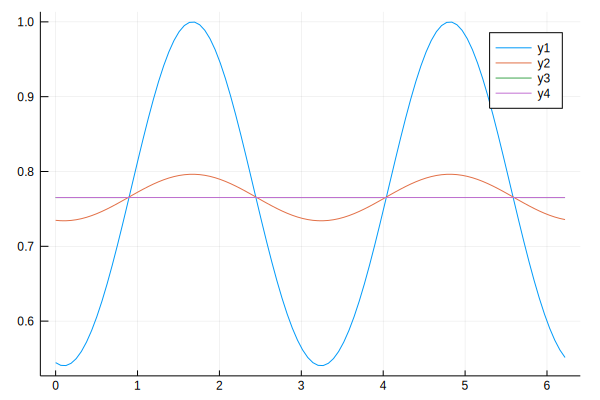

In [23]:
using ApproxFun, Sundials
using Plots; gr()

S = Fourier()
n = 100
T = ApproxFun.plan_transform(S, n)
Ti = ApproxFun.plan_itransform(S, n)
x = points(S, n)


u₀ = T*cos.(cos.(x-0.1)) # Convert the initial condition to Fourier space
D2 = Derivative(S,2)
L = D2[1:n,1:n]

# Simple Heat

function heat(du,u,L,t)
    A_mul_B!(du, L, u) # The equation is trivial in Fourier space
end
prob = ODEProblem(heat, u₀, (0.0,10.0),L)
# Specialize the linear solver on the diagonalness of the Jacobian
u = solve(prob, CVODE_BDF(linear_solver=:Diagonal); reltol=1e-8,abstol=1e-8)
plot(x,Ti*u(0.0)) # The solution is in Fourier space, so use inverse to transform back
plot!(x,Ti*u(0.5))
plot!(x,Ti*u(2.0))
plot!(x,Ti*u(10.0))

## Pseudospectral Solving the Reaction-Diffusion Equation

Take the PDE

$$ u_t = u_{xx} + f(u,t)$$

For some nonlinear $u$. In the Fourier basis, $u_{xx} = Au$ for a diagonal matrix $u$, so this is a nice way to solve the Heat Equation as above (by solving in Fourier space, and converting the solution back). We can solve a nonlinear equation by, whenever we need to apply the nonlinear $f$, transform $u$ back to the origional coordinates and applying $f$ on $u$ before transforming back. This pseudospectral discretization is seen as:

$$ \mathcal{F}u' = A\mathcal{F}u + \mathcal{F}(f(\mathcal{F}^{-1}u,t)) $$

gives an ODE for how $\mathcal{F}u$ evolves, and from that we can recover the true solution via the inverse Fourier transform $\mathcal{F}^{-1}(\mathcal{F}u)$

## Implicit-Explicit (IMEX) Integrators

But wait, we shouldn't solve this as one whole ODE. If we split the ODE into two parts:

$$ u' = f(u,p,t) = f_1(u,p,t) + f_2(u,p,t) $$

then we notice that the first part is the linear part and has the stiff term, while the second part is nonlinear and (can be) non-stiff. **If we only are implicit on the first part, we can use a linear solver instead of a nonlinear solver to significantly reduce the amount of work!** Integrators which allow you to split and do two separate methods at the same time are called IMEX integrators.

In DifferentialEquations.jl, IMEX integrators to be aware of are:

- `CNAB2`
- `SBDF2`
- `KenCarp3`
- `KenCarp4`

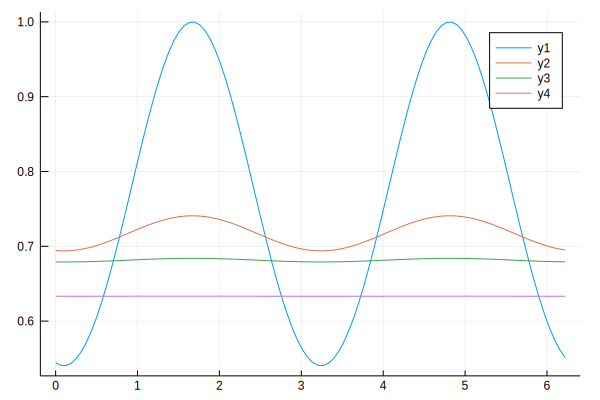

In [27]:
# L is the linear operator from the Heat Equation from before
tmp = similar(u₀)
function f(dû,û,tmp,t)
    A_mul_B!(tmp,Ti,û) # Transform u back to point-space
    @. tmp = 0.75sqrt(tmp) - tmp # apply nonlinear function 0.75sqrt(u)-u in point-space
    A_mul_B!(dû,T,tmp) # Transform back to Fourier space
end

using DiffEqOperators
# Turn L into a linear operator DiffEq can recognize
# By making it Diagonal, DiffEq internally specializes the linear solver
A = DiffEqArrayOperator(Diagonal(L)) 

# Define u' = Au + f
prob = SplitODEProblem(A, f, u₀, (0.0,10.0),tmp)

# Note: use the linsolve argument to pass alternative linear solver methods!
# The linear solver can be swapped out for other methods like preconditioned GMRES
u = solve(prob, KenCarp4())
plot(x,Ti*u(0.0))
plot!(x,Ti*u(0.5))
plot!(x,Ti*u(1.0))
plot!(x,Ti*u(2.0))

## Exponential Integrators 

A more recent set of integrators are the exponential integrators. These methods do not require solving a linear system, thus avoiding the most costly calculation of the implicit methods. However, they must perform a Krylov version of matrix exponential times vector multiplications, $w = exp(\gamma*A)v$. Recent literature has been showing large performance gains of exponential integrators over traditional implicit methods. DifferentialEquations.jl is the first open source library in a high performance language to include exponential integrators, and a brand new (adaptive) Krylov-based approach for large sparse systems was just released as part of GSoC 2018. These methods will be continued to be improved but are ready for widespread use and benchmarking is to come.

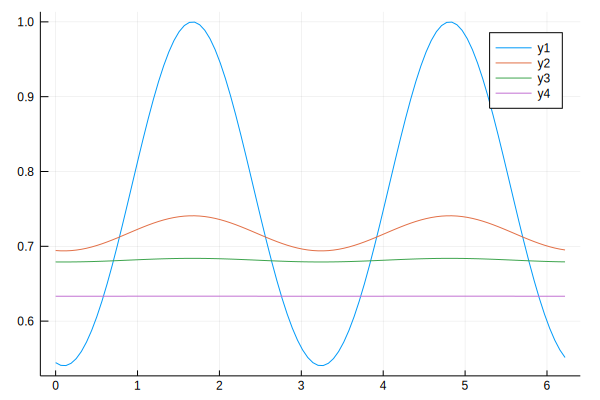

In [29]:
u = solve(prob, ETDRK4(), dt=0.1)
plot(x,Ti*u(0.0))
plot!(x,Ti*u(0.5))
plot!(x,Ti*u(1.0))
plot!(x,Ti*u(2.0))

## Note

Additional methods in DifferentialEquations.jl should be explored. The Runge-Kutta Chebyshev methods are stabilized explicit methods which can solve stiff equations without linear solving. Options allow for swapping out the internal Newton method to Picard and Anderson iteration to not require linear solving. Passing a `linsolve` allows you to take control over the linear solver technique: make it an AMG-preconditioned GMRES. Please see the documentation for a full feature list.

## SSP Methods

Strong-Stability Presurving Runge-Kutta methods are "more stable" explicit methods for PDEs. Some PDEs, like hyperbolic PDEs, are not amenable to implicit solvers and thus require explicit solvers. SSPRK methods can increase the allowable stepsize to increase the efficiency!

## Part 3.3 Recap

PDEs can also be solved by leaving an axis undiscretized and using an ODE solver. This can increase efficiency, stability, and reduce memory consumption. Classes of methods to utilize are:

- Implicit and Rosenbrock(-W) Methods
- IMEX Methods
- Exponential Integrators
- Runge-Kutta Chebyshev Methods
- SSPRK Methods

## Why Julia?

- IterativeSolvers.jl is:
    * Compatible with matrix-free types via `*` overloads
    * Able to be used in the nonlinear and ODE solvers
- BandedMatrices.jl and BlockBandedMatrices.jl are:
    * One of a kind packages for specialization of linear solvers on common PDE matrix types
- KINSOL from Sundials.jl, and soon NLsolve.jl, are:
    * A globalized Newton method with the ability to chose preconditioned-Krylov linear solvers
    * Able to utilize Anderson acceleration to avoid linear solving
- DifferentialEquations.jl is:
    * One of 3 open-source ODE suites with IMEX integrators (Sundials ARKODE and PETSc). 
    * One of 3 open-source ODE suites (EXPINT and ExpoKit in MATLAB) with exponential integrators, and the only one with the newest class of EPIRK methods. 
    * One of two suites with Runge-Kutta Chebyshev methods (Hairer's Suite). It is the only one with high order adaptive SSPRK methods.
- Julia is a language which allows for zero-cost abstractions, letting one compile code specific to the application and compose packages without extra overhead

The native Julia methods of DifferentialEquations.jl also let you swap in all of the Julia tools for linear solvers and allows type-genericity (which allows the use of GPUs for example), allowing you to utilize the full arsenal of tools with these unique implementations.

## Conclusion: Solving PDEs Takes Layers of Tools

You need discretization tooling, linear solvers, nonlinear solvers, and finally ODE solvers to build an efficient PDE solver.

We showed how you can use simple loops to write simple PDE solvers, but the efficient methods require using packages in order to get the latest and most efficient methods.

Many of the latest and most efficient methods only have implementations in Julia, and the JuliaDiffEq organization is committed to continuing the development of such toolling.

## Near Future

In the near future we with to provide a set of problem types and algorithms for common PDEs. Example: Reaction-Diffusion Equation

$$ u_t = u_{xx} + f(u,t) $$

In [ ]:
# Define the PDE problem to solve
prob = ReactionDiffusionProblem(domain,discretization,f)
# Solve it with a pseudospectral IMEX method
solve(prob,Pseudospectral(KenCarp4())
# Or an EPIRK method
solve(prob,FiniteDifference(EXPRB53s3()))

#### We are now very close.

# Acknowledgments

I am deeply indebted to every JuliaDiffEq contributor. I would like to especially those who have specifically been involved in developing the large range of tools which have been demonstrated in this talk:

Gabriel Gellner
Ethan Levien
Scott P. Jones
Lyndon White
@finmod
@dextorious
Viral Shah
Vijay Ivaturi
Andreas Rossler
Ernst Hairer
Lawrance F. Shampine